# setup

In [1]:
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from pesq import pesq
from pesq import PesqError

In [3]:
import librosa

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [4]:
from pystoi.stoi import stoi

In [5]:
import sewar.full_ref as sewar

In [6]:
from scipy.signal import lfilter, hamming
from scipy.linalg import solve_toeplitz, toeplitz

# data

In [7]:
input_file = 'model_outputs/lusiadas_mol.wavernn/1000k_steps_1_gen_batched_target11000_overlap550.wav'
reference_file = 'model_outputs/lusiadas_mol.wavernn/1000k_steps_1_target.wav'

In [8]:
ref_files = pd.read_csv('ref_test_set.txt', header = None)
gen_files = pd.read_csv('gen_test_set.txt', header = None)

In [9]:
for idx, row in ref_files.iterrows():
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    print(ref_file, gen_file)

model_outputs/lusiadas_mol.wavernn/1000k_steps_100_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_100_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_101_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_101_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_102_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_102_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_103_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_103_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_104_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_104_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_105_target.wav model_outputs/lusiadas_mol.wavernn/1000k_steps_105_gen_batched_target11000_overlap550.wav
model_outputs/lusiadas_mol.wavernn/1000k_steps_106_target.wav model_outputs/lusiadas_mol

# utils

In [10]:
def load_audio(file_path):
    data, rate = sf.read(file_path)
    return data, rate

# pesq

In [11]:
def calculate_pesq(reference_file, degraded_file):
    try:
        ref, rate_ref = load_audio(reference_file)
        deg, rate = load_audio(degraded_file)
        assert rate == rate_ref

        # if len(ref) > len(deg):
        #     ref = ref[:len(deg)]
        # else:
        #     deg = deg[:len(ref)]

        pesq_score = pesq(rate, ref, deg, 'nb')
        
        return pesq_score
    except PesqError as e:
        print(f"PESQ Error: {e}")
        return None

In [12]:
pesq_score = calculate_pesq(reference_file, input_file)
pesq_score

2.472633123397827

In [13]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    pesq_score = calculate_pesq(ref_file, gen_file)
    log.append(pesq_score)

279it [01:22,  3.38it/s]


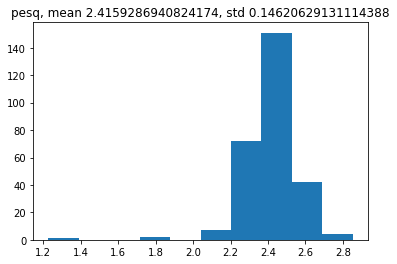

In [14]:
plt.hist(log);
plt.title('pesq, mean {}, std {}'.format(np.mean(log), np.std(log)));

# snr

In [15]:
def calculate_snr(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    if len(ref) > len(deg):
        ref = ref[:len(deg)]
    else:
        deg = deg[:len(ref)]

    noise = ref - deg
    signal_power = np.mean(ref ** 2)
    noise_power = np.mean(noise ** 2)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [16]:
snr_score = calculate_snr(reference_file, input_file)
snr_score

-2.7594857856751984

In [17]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    snr_score = calculate_snr(ref_file, gen_file)
    log.append(snr_score)

279it [00:00, 430.96it/s]


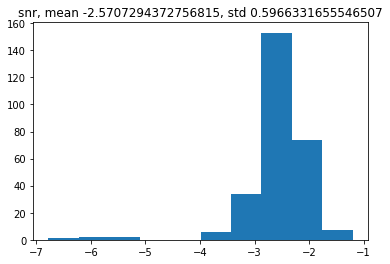

In [18]:
plt.hist(log);
plt.title('snr, mean {}, std {}'.format(np.mean(log), np.std(log)));

# mfcc dtw

In [19]:
def calculate_mfcc(audio, rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=n_mfcc)
    return mfccs.T

def compare_mfcc(reference_file, degraded_file, n_mfcc=13):
    ref_audio, rate_ref = load_audio(reference_file)
    deg_audio, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    ref_mfcc = calculate_mfcc(ref_audio, rate_ref, n_mfcc = n_mfcc)
    deg_mfcc = calculate_mfcc(deg_audio, rate_deg, n_mfcc = n_mfcc)

    distance, path = fastdtw(ref_mfcc, deg_mfcc, dist=euclidean)
    return distance

In [20]:
mfccdtw_score = compare_mfcc(reference_file, input_file)
mfccdtw_score

18233.564982105363

In [21]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    mfccdtw_score = compare_mfcc(ref_file, gen_file)
    log.append(mfccdtw_score)

279it [00:29,  9.45it/s]


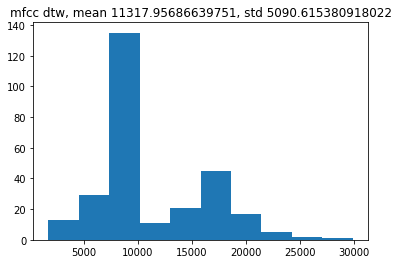

In [22]:
plt.hist(log);
plt.title('mfcc dtw, mean {}, std {}'.format(np.mean(log), np.std(log)));

# stoi

In [23]:
def calculate_stoi(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    if len(ref) > len(deg):
        ref = ref[:len(deg)]
    else:
        deg = deg[:len(ref)]

    stoi_score = stoi(ref, deg, rate_ref, extended=False)
    return stoi_score

In [24]:
stoi_score = calculate_stoi(reference_file, input_file)
stoi_score

0.8730798412882078

In [25]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    stoi_score = calculate_stoi(ref_file, gen_file)
    log.append(stoi_score)

279it [00:22, 12.22it/s]


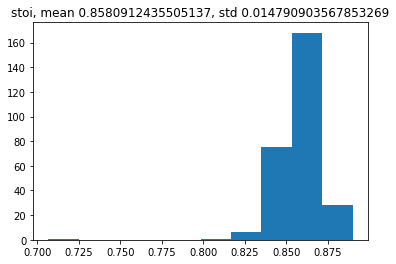

In [26]:
plt.hist(log);
plt.title('stoi, mean {}, std {}'.format(np.mean(log), np.std(log)));

# composite

In [27]:
def calculate_ccc(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    # min_len = min(len(ref_audio), len(deg_audio))
    # ref_audio = ref_audio[:min_len]
    # deg_audio = deg_audio[:min_len]

    csig = sewar.csig(ref, deg)
    cbak = sewar.cbak(ref, deg)
    covl = sewar.covl(ref, deg)

    return csig, cbak, covl

In [21]:
# csig, cbak, covl = calculate_ccc(reference_file, input_file)
# csig, cbak, covl

AttributeError: module 'sewar.full_ref' has no attribute 'csig'

# lsd

In [28]:
def log_spectral_distance(ref_audio, deg_audio, sr):
    ref_spec = np.log(np.abs(librosa.stft(ref_audio)) + 1e-10)
    deg_spec = np.log(np.abs(librosa.stft(deg_audio)) + 1e-10)

    lsd = np.mean(np.sqrt(np.mean((ref_spec - deg_spec) ** 2, axis=0)))
    return lsd

def calculate_lsd(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    min_len = min(len(ref), len(deg))
    ref_audio = ref[:min_len]
    deg_audio = deg[:min_len]

    lsd = log_spectral_distance(ref_audio, deg_audio, rate_ref)
    return lsd

In [29]:
lsd_score = calculate_lsd(reference_file, input_file)
lsd_score

0.97800785

In [30]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    lsd_score = calculate_lsd(ref_file, gen_file)
    log.append(lsd_score)

279it [00:06, 44.87it/s]


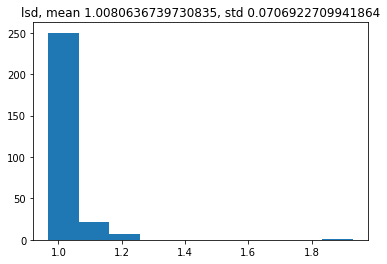

In [31]:
plt.hist(log);
plt.title('lsd, mean {}, std {}'.format(np.mean(log), np.std(log)));

# llr

In [32]:
def frame_signal(signal, frame_length):
    frame_step = frame_length // 2
    signal_length = len(signal)
    num_frames = 1 + int(np.ceil((signal_length - frame_length) / frame_step))
    pad_signal_length = num_frames * frame_step + frame_length
    pad_signal = np.append(signal, np.zeros(pad_signal_length - signal_length))

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
                np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def lpc(signal, order):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]
    R = autocorr[:order + 1]
    r = -autocorr[1:order + 1]

    a = solve_toeplitz((R, R), r)
    return np.concatenate(([1], a))

def calculate_llr(reference_file, degraded_file, frame_length=512):
    ref_audio, rate_ref = load_audio(reference_file)
    deg_audio, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")
    
    # Ensure the signals have the same length
    min_len = min(len(ref_audio), len(deg_audio))
    ref_audio = ref_audio[:min_len]
    deg_audio = deg_audio[:min_len]
    
    ref_frames = frame_signal(ref_audio, frame_length)
    deg_frames = frame_signal(deg_audio, frame_length)
   
    llr_values = []
    for ref_frame, deg_frame in zip(ref_frames, deg_frames):
        ref_frame = ref_frame * hamming(frame_length)
        deg_frame = deg_frame * hamming(frame_length)

        ref_lpc = lpc(ref_frame, order=12)
        deg_lpc = lpc(deg_frame, order=12)

        ref_pred = lfilter([0] + -1 * ref_lpc[1:], 1, ref_frame)
        deg_pred = lfilter([0] + -1 * deg_lpc[1:], 1, ref_frame)

        error_signal = ref_pred - deg_pred
        num = np.dot(error_signal, error_signal)
        denom = np.dot(ref_pred, ref_pred)

        llr_frame = 10 * np.log10(num / denom)
        llr_values.append(llr_frame)

    return np.mean(llr_values)

In [30]:
# llr_score = calculate_llr(reference_file, input_file)
# llr_score

ValueError: incompatible dimensions